# Argo Section in NATRE Region Studied in Ferrari 2005

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw

import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf

## Section Selection

In [2]:
box = [-32,-26,23,29,0,2000]

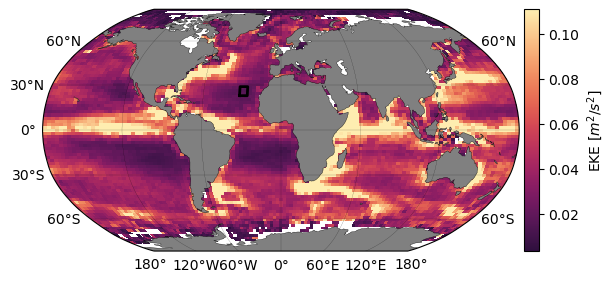

In [3]:
pf.plot_box([box])

In [8]:
scales = [50,100,200]
sample_max = 12
variable = 'SPICE'

In [9]:
sect = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-32,-26)_lat:(23,29)_ds_z.nc')
sect_EKE = ef.get_EKE_da(sect,scales,sample_max,variable)

In [10]:
sect_SIG1 = gsw.density.sigma1(sect.SA, sect.CT)
sect = sect.assign(SIG1=(['N_PROF','PRES_INTERPOLATED'], sect_SIG1.data))

In [11]:
sect

<xarray.Dataset>
Dimensions:            (N_PROF: 332, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF             (N_PROF) int64 1570 1574 1632 1578 ... 871 3469 872 873
    TIME               (N_PROF) datetime64[ns] 2006-08-26T04:30:02.000000256 ...
    LATITUDE           (N_PROF) float64 ...
    LONGITUDE          (N_PROF) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1992 1994 1996 1998
    N_PROF_NEW         (N_PROF) int64 ...
    MLD                (N_PROF) int64 ...
    month              (N_PROF) int64 ...
    month_frac         (N_PROF) float64 ...
    year               (N_PROF) int64 ...
    year_frac          (N_PROF) float64 ...
Data variables: (12/13)
    CT                 (N_PROF, PRES_INTERPOLATED) float64 ...
    CYCLE_NUMBER       (N_PROF) int64 ...
    DATA_MODE          (N_PROF) object ...
    DIRECTION          (N_PROF) object ...
    PLATFORM_NUMBER    (N_PROF) int64 ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 ...
    ...                 ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 6.651 6.651 ... 0.358
    SIG1               (N_PROF, PRES_INTERPOLATED) float64 29.51 29.51 ... 32.45
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/30
    Fetched_constraints:  [x=-32.00/-26.00; y=23.00/29.00; z=0.0/2000.0]
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...

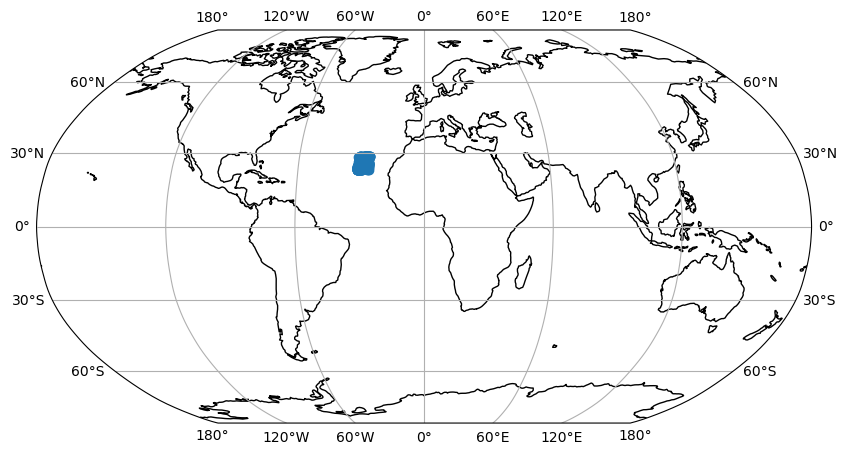

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()
ax.gridlines(draw_labels=True)
ax.scatter(sect.LONGITUDE,sect.LATITUDE,transform=ccrs.PlateCarree())

## T,S,SIG0,SPICE Sections

In [15]:
#        CT                     SA                      SIG0                    SPICE                CT gradient                  SA gradient
names = [cmo.thermal,           cmo.haline,             cmo.dense,              cmo.deep,            cmo.balance,                 cmo.balance]
bounds = [np.linspace(-2,22,7), np.linspace(33,36.5,8), np.linspace(24,28.5,6), np.linspace(-2,5,7), np.linspace(-0.04,0.04,10), np.linspace(-0.004,0.004,10)]
cmaps = []
norms = []

for n in range(0,len(names)):
    cmap = names[n]
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds[n], cmap.N)
    
    cmaps.append(cmap)
    norms.append(norm)

In [16]:
sect = sect.sortby('LATITUDE')
EKE = sect_EKE.sortby('LATITUDE').where(sect_EKE.mask==1)

levels0  = np.linspace(sect.isel(PRES_INTERPOLATED=slice(200,2000)).SIG0.min(),sect.isel(PRES_INTERPOLATED=slice(200,2000)).SIG0.max(),8)
levels1  = np.linspace(sect.isel(PRES_INTERPOLATED=slice(200,2000)).SIG1.min(),sect.isel(PRES_INTERPOLATED=slice(200,2000)).SIG1.max(),8)

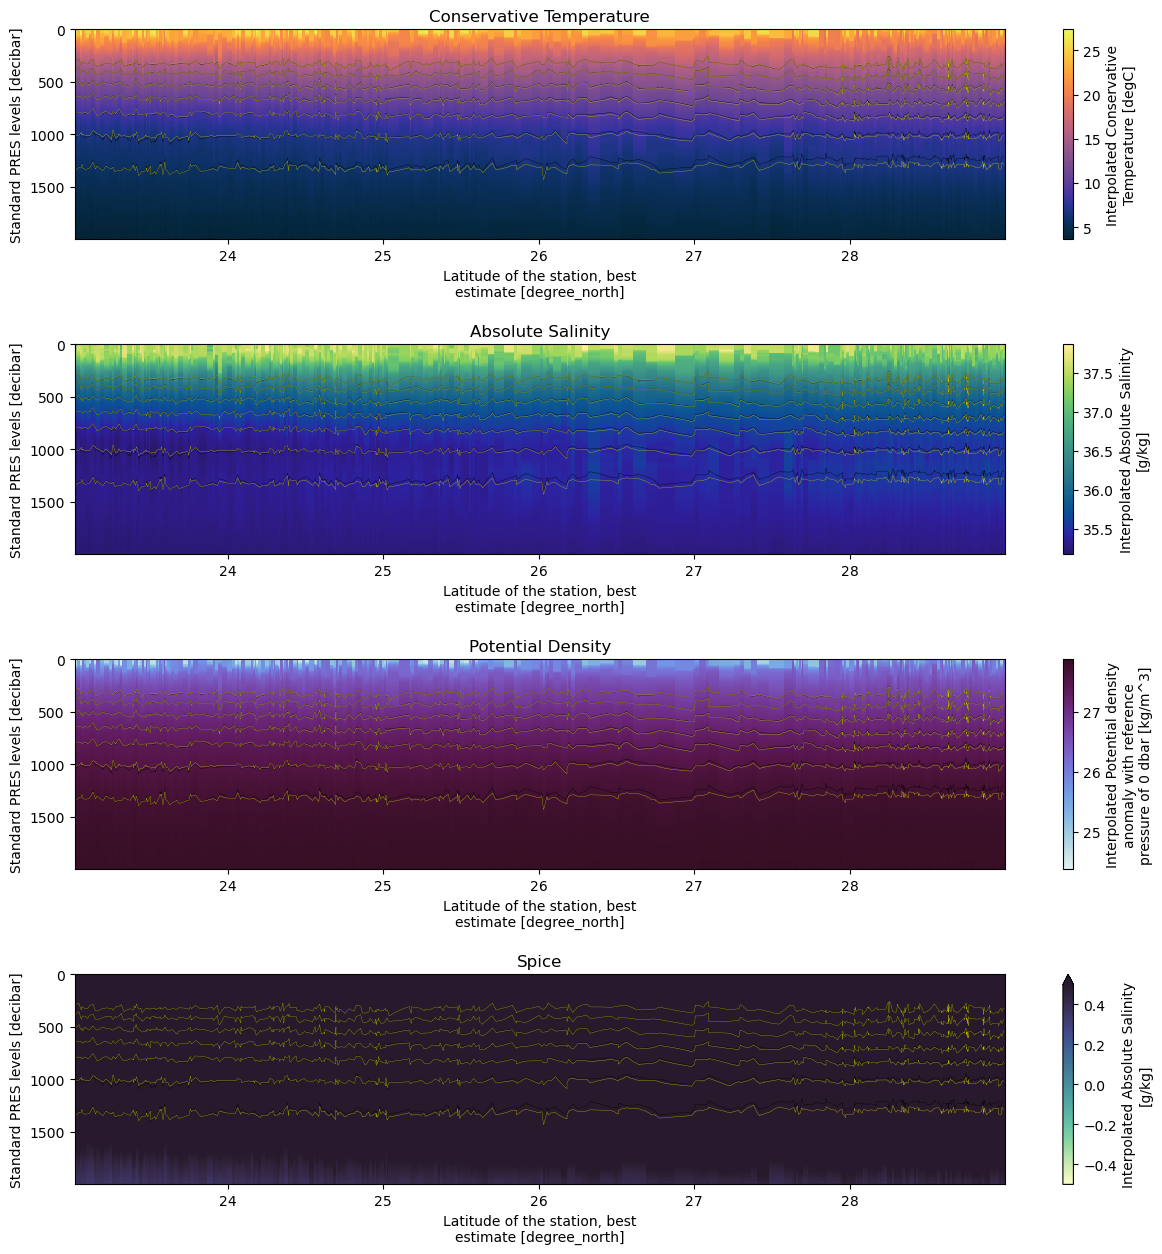

In [22]:
plt.figure(figsize=(15,15))

plt.subplot(411)
sect.CT.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.thermal)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.title('Conservative Temperature')

plt.subplot(412)
sect.SA.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.haline)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.title('Absolute Salinity')

plt.subplot(413)
sect.SIG0.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.title('Potential Density')

plt.subplot(414)
sect.SPICE.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.deep,vmin=-0.5)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplots_adjust(hspace=0.5)

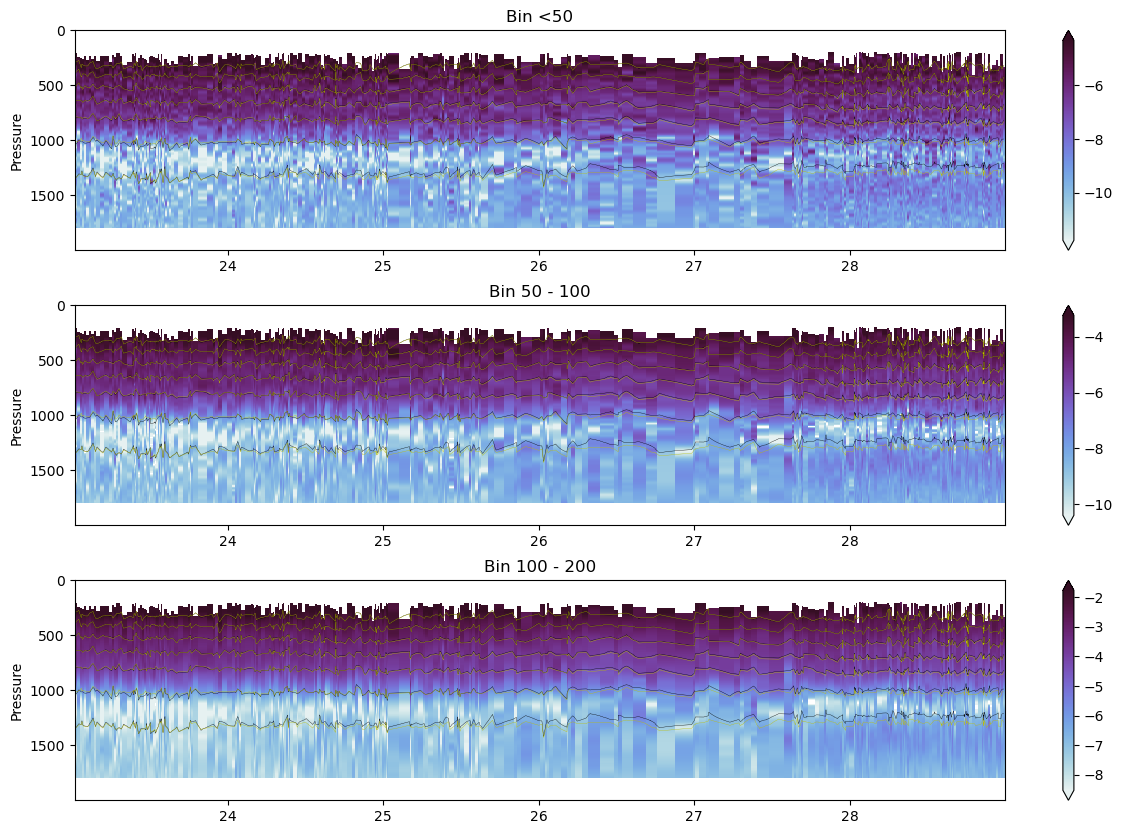

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(311)
np.log(EKE.isel(EKE=0)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('Bin <{}'.format(scales[0]))

plt.subplot(312)
np.log(EKE.isel(EKE=1)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('Bin {} - {}'.format(scales[0], scales[1]))

plt.subplot(313)
np.log(EKE.isel(EKE=2)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('Bin {} - {}'.format(scales[1], scales[2]))

plt.subplots_adjust(hspace=0.25)

## Gradient Plots

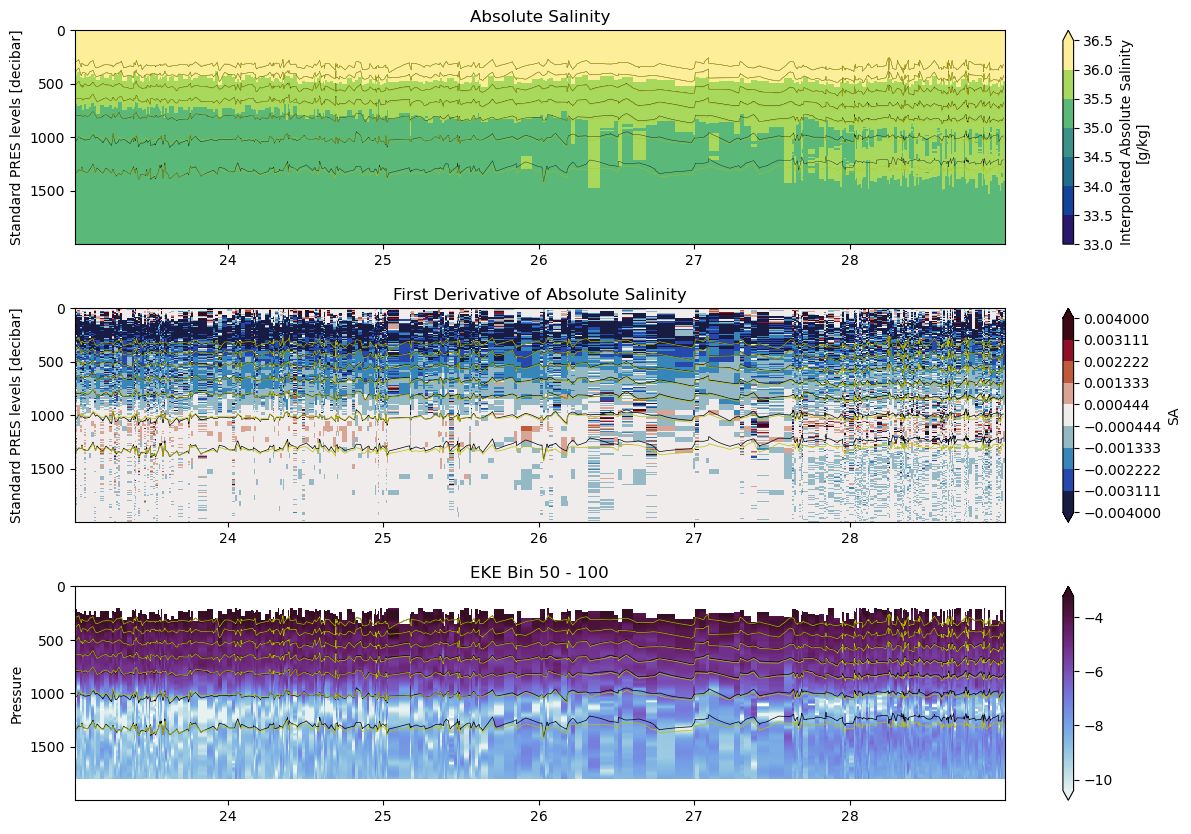

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(311)
sect.SA.plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[1], norm=norms[1])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.25)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.25)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('Absolute Salinity')

plt.subplot(312)
sect.SA.differentiate('PRES_INTERPOLATED').plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmaps[5], norm=norms[5])
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.5)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.5)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.title('First Derivative of Absolute Salinity')

plt.subplot(313)
np.log(EKE.isel(EKE=1)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense,robust=True)
sect.SIG0.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels0, colors='k', linewidths=0.5)
sect.SIG1.plot.contour(x='LATITUDE', y='PRES_INTERPOLATED', levels=levels1, colors='y', linewidths=0.5)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Pressure')
plt.title('EKE Bin {} - {}'.format(scales[0], scales[1]))

plt.subplots_adjust(hspace=0.3)

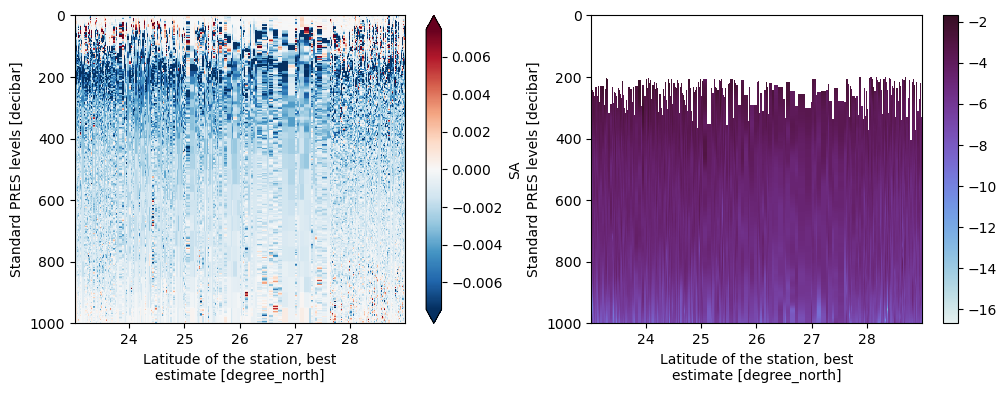

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sect.SA.differentiate('PRES_INTERPOLATED').plot(x='LATITUDE',y='PRES_INTERPOLATED',robust=True)
plt.ylim(1000,0)

plt.subplot(122)
np.log(EKE.isel(EKE=1)).plot(x='LATITUDE',y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.ylim(1000,0)

plt.subplots_adjust(wspace=0.25)